In [250]:
NMS_IOU_THRES = 0.6

IOU_THRES = 0.5

NC = 8
class_names = ['Black non occluded', 'Brown non occluded', 'Gray non occluded', 'White non occluded','Black occluded', 'Brown occluded', 'Gray occluded', 'White occluded']
CONF_STEPS = 1001
IOU_STEPS = 10
model = "Mixed-m"

In [251]:
def parseLabel(label: str) -> dict:
    values = label.split()
    dict = {}
    dict["class"] = int(values[0])
    if len(values) > 5:
        dict["conf"] = float(values[5])
    
    xc = float(values[1])
    yc = float(values[2])
    width = float(values[3])
    height = float(values[4])

    dict["x1"] = xc - width / 2
    dict["x2"] = xc + width / 2
    dict["y1"] = yc - height / 2
    dict["y2"] = yc + height / 2

    return dict

def iou(l1: dict, l2: dict):
    x1 = max(l1["x1"], l2["x1"])
    x2 = min(l1["x2"], l2["x2"])
    y1 = max(l1["y1"], l2["y1"])
    y2 = min(l1["y2"], l2["y2"])
    
    ia = max(0, x2 - x1) * max(0, y2 - y1)
    l1a = (l1["x2"] - l1["x1"]) * (l1["y2"] - l1["y1"])
    l2a = (l2["x2"] - l2["x1"]) * (l2["y2"] - l2["y1"])

    ua = l1a + l2a - ia

    return ia / ua

In [252]:
import os
import numpy as np

testLabelDir = f"tests/{model}/labels"
groundTruthLabelDir = f"dataset/labels"

testLabelFiles = list(filter(lambda x: x.endswith("txt"), os.listdir(testLabelDir)))

conf_thresholds = np.linspace(0, 1, CONF_STEPS)
iouv = np.linspace(0.5, 0.95, IOU_STEPS)

true_positives = np.zeros((NC, len(conf_thresholds), IOU_STEPS))
false_positives = np.zeros((len(conf_thresholds)))
false_negatives = np.zeros((NC, len(conf_thresholds), IOU_STEPS))

instance_count = np.zeros((NC))
image_count = len(testLabelFiles)

for labelFile in testLabelFiles:

    with open(f"{groundTruthLabelDir}/{labelFile}") as gFile, open(f"{testLabelDir}/{labelFile}") as tFile:
        gLabels = gFile.readlines()
        tLabels = tFile.readlines()
    
    gBoxes = [parseLabel(label) for label in gLabels]
    proposalBoxes = [parseLabel(label) for label in tLabels]
    tBoxes = []

    for gBox in gBoxes:
        instance_count[gBox["class"]] += 1

    # NMS
    while(len(proposalBoxes) > 0):
        currentBox = proposalBoxes.pop(0)
        tBoxes.append(currentBox)
        for (i, proposalBox) in enumerate(proposalBoxes):
            if iou(currentBox, proposalBox) >= NMS_IOU_THRES:
                proposalBoxes.pop(i)

    for tBox in tBoxes:
        tp = False
        for (i, gBox) in enumerate(gBoxes):
            for k, iou_thres in enumerate(iouv):
                if iou(tBox, gBox) >= iou_thres:
                    tp = True

                    for (j, conf_threshold) in enumerate(conf_thresholds):
                        if (tBox["conf"] >= conf_threshold):
                            true_positives[gBox["class"], j, k] += 1

                        if (conf_threshold > tBox["conf"]):
                            false_negatives[gBox["class"], j, k] += 1

            if tp:
                gBoxes.pop(i)
                break
        
        if not tp:
            for (j, conf_threshold) in enumerate(conf_thresholds):
                if (tBox["conf"] >= conf_threshold):
                    false_positives[j] += 1
    
    for (j, conf_threshold) in enumerate(conf_thresholds):
        for gBox in gBoxes:
            false_negatives[gBox["class"], j, :] += 1
    


In [253]:
tp0_5 = true_positives[:,:,0]
fn0_5 = false_negatives[:,:,0]

In [254]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
ticks = np.linspace(0, 1, 11)

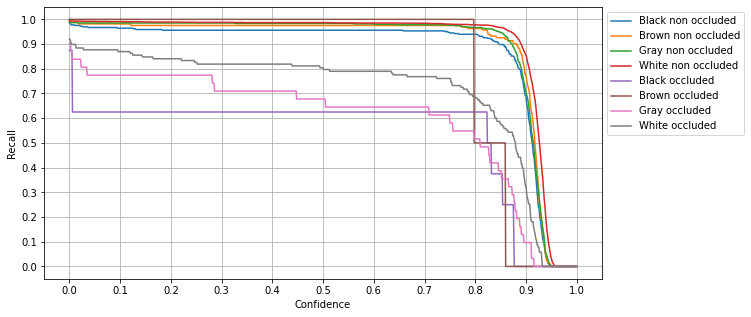

In [255]:
for c in range(NC):
    plt.plot(conf_thresholds, tp0_5[c]/instance_count[c], label=class_names[c])

plt.legend(bbox_to_anchor=(1.0,1.0))
plt.xlabel("Confidence")
plt.ylabel("Recall")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

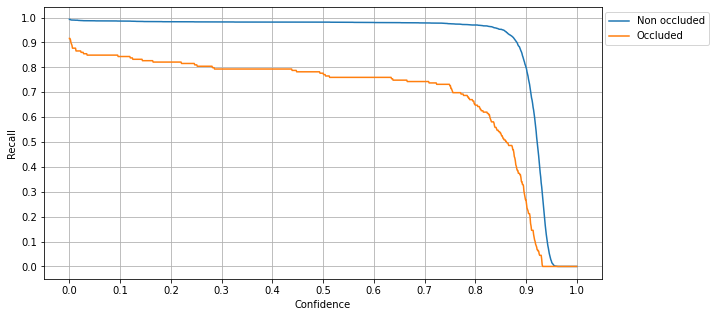

In [256]:
nonoccluded = tp0_5[:4].sum(axis=0) / instance_count[:4].sum()
occluded = tp0_5[4:].sum(axis=0) / instance_count[4:].sum()

plt.plot(conf_thresholds, nonoccluded, label="Non occluded")
plt.plot(conf_thresholds, occluded, label="Occluded")

plt.legend(bbox_to_anchor=(1.2,1.0))
plt.xlabel("Confidence")
plt.ylabel("Recall")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

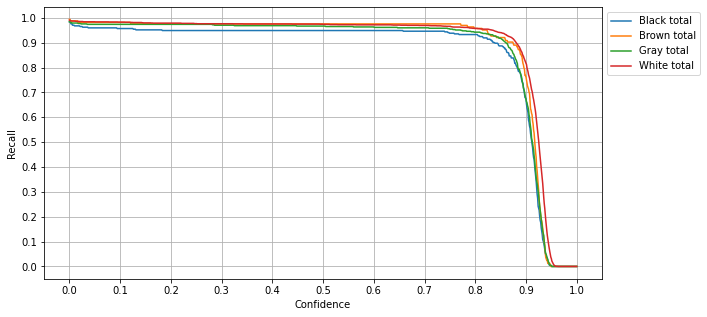

In [257]:
black = tp0_5[[0,4]].sum(axis=0) / instance_count[[0,4]].sum()
brown = tp0_5[[1,5]].sum(axis=0) / instance_count[[1,5]].sum()
gray = tp0_5[[2,6]].sum(axis=0) / instance_count[[2,6]].sum()
white = tp0_5[[3,7]].sum(axis=0) / instance_count[[3,7]].sum()

plt.plot(conf_thresholds, black, label="Black total")
plt.plot(conf_thresholds, brown, label="Brown total")
plt.plot(conf_thresholds, gray, label="Gray total")
plt.plot(conf_thresholds, white, label="White total")

plt.legend(bbox_to_anchor=(1.0,1.0))
plt.xlabel("Confidence")
plt.ylabel("Recall")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

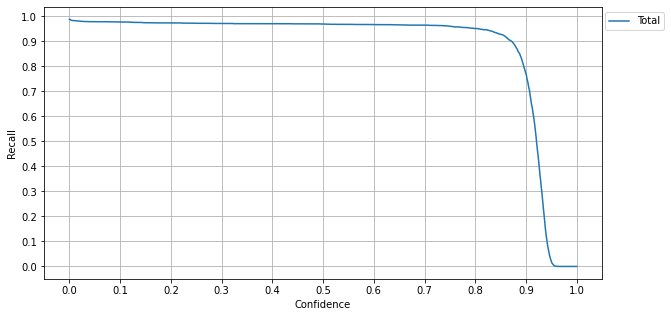

In [258]:
total_recall = tp0_5.sum(axis=0) / instance_count.sum()

plt.plot(conf_thresholds, total_recall, label="Total")
plt.legend(bbox_to_anchor=(1.12,1.0))
plt.xlabel("Confidence")
plt.ylabel("Recall")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

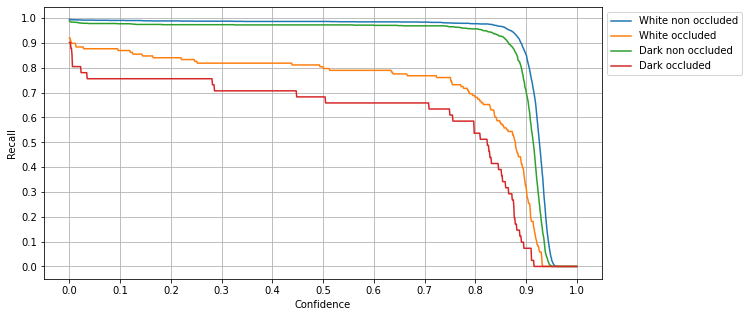

In [259]:
white_non_occ = tp0_5[3] / instance_count[3]
white_occ = tp0_5[7] / instance_count[7]

dark_non_occ = tp0_5[:3].sum(axis=0) / instance_count[:3].sum()
dark_occ = tp0_5[4:7].sum(axis=0) / instance_count[4:7].sum()

plt.plot(conf_thresholds, white_non_occ, label="White non occluded")
plt.plot(conf_thresholds, white_occ, label="White occluded")
plt.plot(conf_thresholds, dark_non_occ, label="Dark non occluded")
plt.plot(conf_thresholds, dark_occ, label="Dark occluded")

plt.legend(bbox_to_anchor=(1.0,1.0))
plt.xlabel("Confidence")
plt.ylabel("Recall")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

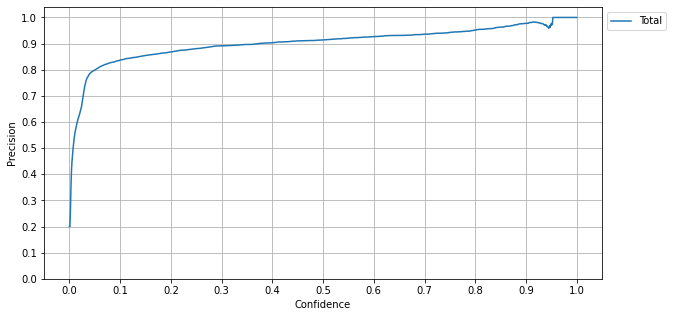

In [260]:
tp_total = tp0_5.sum(axis=0)
tp_fp = tp_total + false_positives

precision = np.divide(tp_total, tp_fp, np.ones_like(tp_total), where=(tp_fp > 0))

plt.plot(conf_thresholds, precision, label="Total")

plt.legend(bbox_to_anchor=(1.0,1.0))
plt.xlabel("Confidence")
plt.ylabel("Precision")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

In [261]:
pr = np.flip(np.column_stack([total_recall, precision]), axis=1)
precision_recall = np.array([np.amax(pr[:, 1], where=pr[:, 0] >= conf_thresholds[i], initial=0) for i in range(CONF_STEPS)])

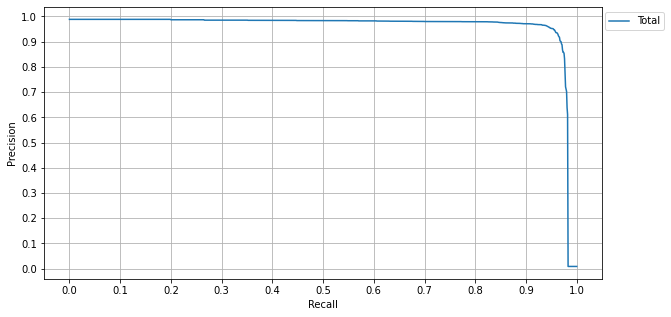

In [262]:
plt.plot(recall, precision_recall, label="Total")
plt.legend(bbox_to_anchor=(1.12,1.0))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

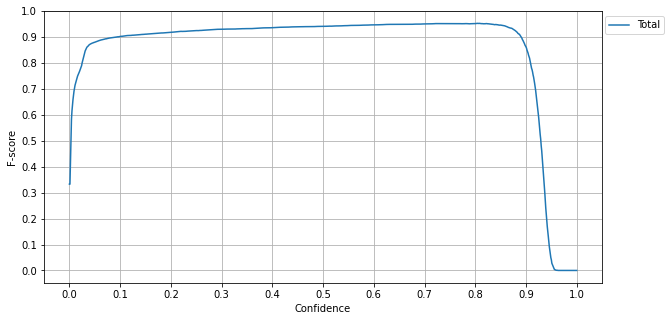

In [263]:
fn_total = fn0_5.sum(axis=0)

f_score = tp_total / (tp_total + 0.5 * (false_positives + fn_total))

plt.plot(conf_thresholds, f_score, label="Total")
plt.legend(bbox_to_anchor=(1.12,1.0))
plt.xlabel("Confidence")
plt.ylabel("F-score")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

In [264]:
tp = true_positives.sum(axis=0)
tp_fp = tp + false_positives[:, None]

r = tp / instance_count.sum()
p = np.divide(tp, tp_fp, np.ones_like(tp), where=(tp_fp > 0))

pr = np.flip(np.swapaxes([np.copy(r), np.copy(p)], 0, 2), axis=1)
pr_curve = np.array([[np.amax(pr[i, :, 1], where=pr[i, :, 0] >= conf_thresholds[j], initial=0) for j in range(CONF_STEPS)] for i in range(IOU_STEPS)])

i = 800
mAP50 = pr_curve[0].mean()
mAP = pr_curve.mean(axis=1).mean()
pr = p[i, 0]
re = r[i, 0]
print(f"mAP@.5: {mAP50:.4f}")
print(f"mAP@.5.95: {mAP:.4f}")
print(f"Precision: {pr:.4f}")
print(f"Recall: {re:.4f}")

mAP@.5: 0.9618
mAP@.5.95: 0.7422
Precision: 0.9512
Recall: 0.9518


In [265]:
i = 800#np.argmax(f_score)
max_f_threshold = conf_thresholds[i]
do_re = dark_occ[i]
wo_re = white_occ[i]
o_re = occluded[i]

print(f"Maxium F-Score: {max_f_threshold:.4f}")
print(f"Dark occluded recall: {do_re:.4f}")
print(f"White occluded recall: {wo_re:.4f}")
print(f"Occluded: {o_re:.4f}")

Maxium F-Score: 0.8000
Dark occluded recall: 0.5366
White occluded recall: 0.6812
Occluded: 0.6480


# Comparison

In [233]:
tp_total = tp0_5.sum(axis=0)
tp_fp = tp_total + false_positives

baseline_class_recall = np.array([tp0_5[c]/instance_count[c] for c in range(NC)])
baseline_occluded_recall = tp0_5[4:].sum(axis=0) / instance_count[4:].sum()
baseline_white_occ = tp0_5[7] / instance_count[7]
baseline_dark_occ = tp0_5[4:7].sum(axis=0) / instance_count[4:7].sum()
baseline_total_recall = tp0_5.sum(axis=0) / instance_count.sum()
baseline_precision = np.divide(tp_total, tp_fp, np.ones_like(tp_total), where=(tp_fp > 0))
baseline_pr = np.flip(np.column_stack([baseline_total_recall, baseline_precision]), axis=1)
baseline_precision_recall = np.array([np.amax(baseline_pr[:, 1], where=baseline_pr[:, 0] >= conf_thresholds[i], initial=0) for i in range(CONF_STEPS)])
baseline_f_score = tp_total / (tp_total + 0.5 * (false_positives + fn_total))

In [266]:
tp_total = tp0_5.sum(axis=0)
tp_fp = tp_total + false_positives

mixed_class_recall = np.array([tp0_5[c]/instance_count[c] for c in range(NC)])
mixed_occluded_recall = tp0_5[4:].sum(axis=0) / instance_count[4:].sum()
mixed_white_occ = tp0_5[7] / instance_count[7]
mixed_dark_occ = tp0_5[4:7].sum(axis=0) / instance_count[4:7].sum()
mixed_total_recall = tp0_5.sum(axis=0) / instance_count.sum()
mixed_precision = np.divide(tp_total, tp_fp, np.ones_like(tp_total), where=(tp_fp > 0))
mixed_pr = np.flip(np.column_stack([mixed_total_recall, mixed_precision]), axis=1)
mixed_precision_recall = np.array([np.amax(mixed_pr[:, 1], where=mixed_pr[:, 0] >= conf_thresholds[i], initial=0) for i in range(CONF_STEPS)])
mixed_f_score = tp_total / (tp_total + 0.5 * (false_positives + fn_total))

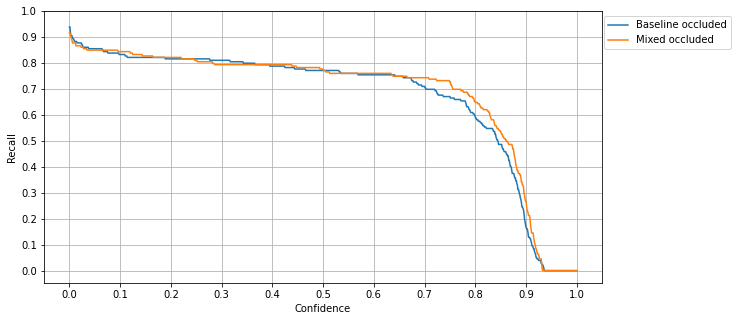

In [272]:
plt.plot(conf_thresholds, baseline_occluded_recall, label="Baseline occluded")
plt.plot(conf_thresholds, mixed_occluded_recall, label="Mixed occluded")

plt.legend(bbox_to_anchor=(1.24,1.0))
plt.xlabel("Confidence")
plt.ylabel("Recall")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

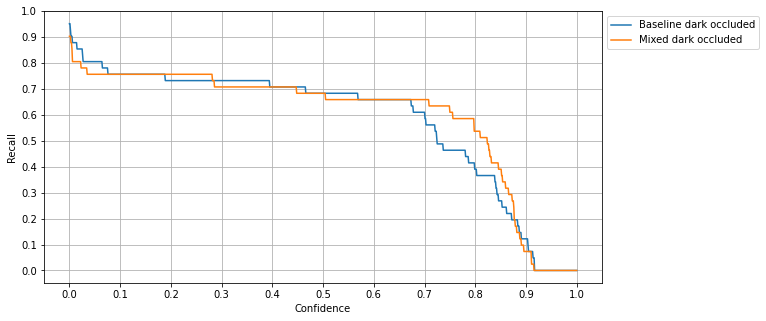

In [278]:
plt.plot(conf_thresholds, baseline_dark_occ, label="Baseline dark occluded")
plt.plot(conf_thresholds, mixed_dark_occ, label="Mixed dark occluded")

plt.legend(bbox_to_anchor=(1.29,1.0))
plt.xlabel("Confidence")
plt.ylabel("Recall")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

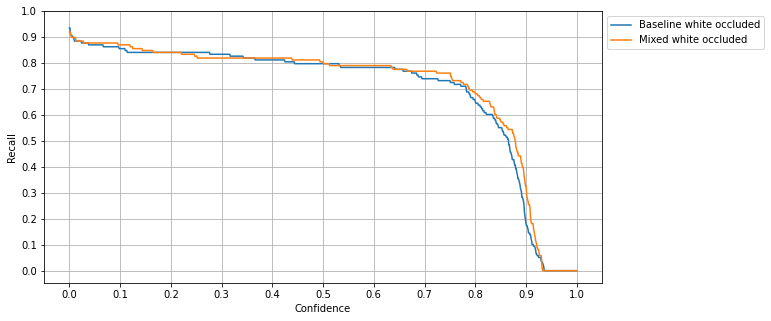

In [316]:
plt.plot(conf_thresholds, baseline_white_occ, label="Baseline white occluded")
plt.plot(conf_thresholds, mixed_white_occ, label="Mixed white occluded")

plt.legend(bbox_to_anchor=(1.3,1.0))
plt.xlabel("Confidence")
plt.ylabel("Recall")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

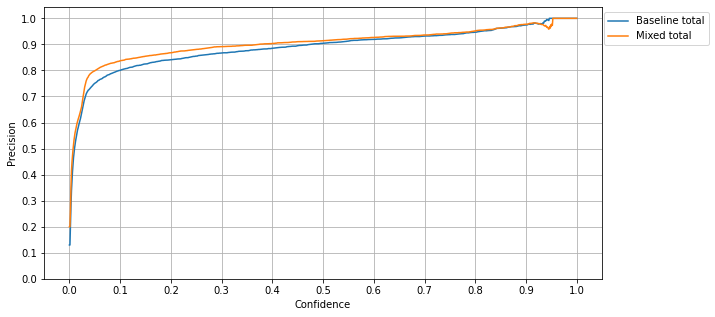

In [324]:
plt.plot(conf_thresholds, baseline_precision, label="Baseline total")
plt.plot(conf_thresholds, mixed_precision, label="Mixed total")

plt.legend(bbox_to_anchor=(1.2,1.0))
plt.xlabel("Confidence")
plt.ylabel("Precision")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

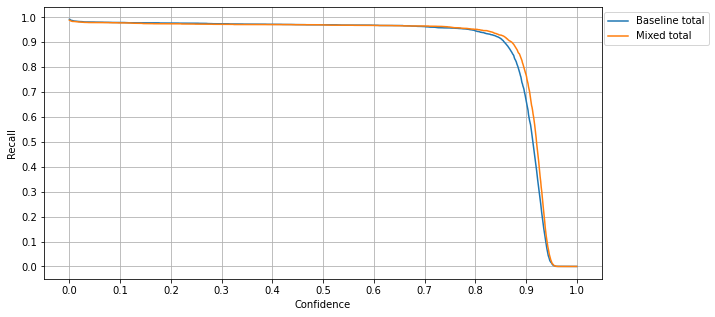

In [342]:
plt.plot(conf_thresholds, baseline_total_recall, label="Baseline total")
plt.plot(conf_thresholds, mixed_total_recall, label="Mixed total")

plt.legend(bbox_to_anchor=(1.2,1.0))
plt.xlabel("Confidence")
plt.ylabel("Recall")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

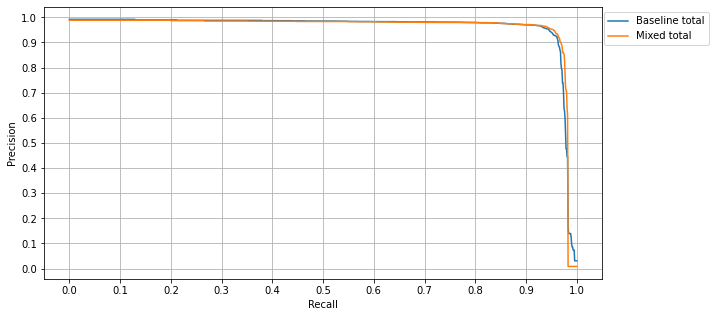

In [321]:
plt.plot(conf_thresholds, baseline_precision_recall, label="Baseline total")
plt.plot(conf_thresholds, mixed_precision_recall, label="Mixed total")

plt.legend(bbox_to_anchor=(1.2,1.0))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

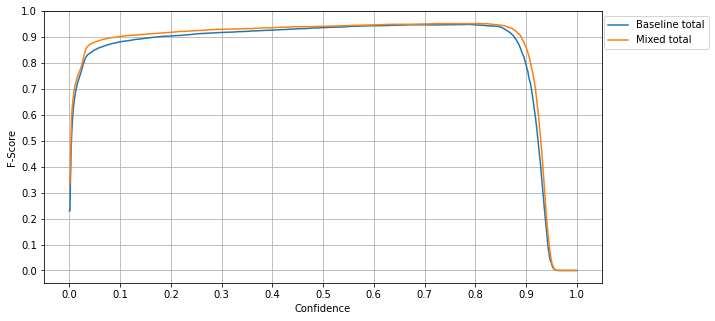

In [319]:
plt.plot(conf_thresholds, baseline_f_score, label="Baseline total")
plt.plot(conf_thresholds, mixed_f_score, label="Mixed total")

plt.legend(bbox_to_anchor=(1.2,1.0))
plt.xlabel("Confidence")
plt.ylabel("F-Score")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

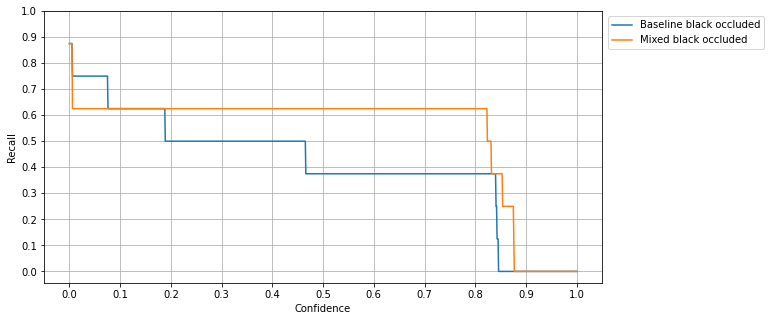

In [314]:
plt.plot(conf_thresholds, baseline_class_recall[4], label="Baseline black occluded")
#plt.plot(conf_thresholds, baseline_class_recall[5], label="Baseline brown occluded", c="darkblue")
#plt.plot(conf_thresholds, baseline_class_recall[6], label="Baseline gray occluded", c="darkgreen")
#plt.plot(conf_thresholds, baseline_class_recall[7], label="Baseline white occluded", c="peru")
plt.plot(conf_thresholds, mixed_class_recall[4], label="Mixed black occluded")
#plt.plot(conf_thresholds, mixed_class_recall[5], label="Mixed brown occluded", c="cornflowerblue")
#plt.plot(conf_thresholds, mixed_class_recall[6], label="Mixed gray occluded", c="lightgreen")
#plt.plot(conf_thresholds, mixed_class_recall[7], label="Mixed white occluded", c="orange")

plt.legend(bbox_to_anchor=(1.3,1.0))
plt.xlabel("Confidence")
plt.ylabel("Recall")
plt.grid(axis="both")
plt.xticks(ticks)
plt.yticks(ticks)
plt.show()

In [348]:
f"{100 * (mixed_occluded_recall[800] / baseline_occluded_recall[800] - 1):.3f}"

'9.434'

In [349]:
f"{100 * (mixed_dark_occ[800] / baseline_dark_occ[800] - 1):.3f}"

'37.500'

In [350]:
f"{100 * (mixed_class_recall[4][800] / baseline_class_recall[4][800] - 1):.3f}"

'66.667'

In [344]:
print(f"Baseline precision {baseline_precision[800]:.4f}")
print(f"Mixed precision {mixed_precision[800]:.4f}")
print(f"Baseline recall {baseline_total_recall[800]:.4f}")
print(f"Mixed recall {mixed_total_recall[800]:.4f}")

Baseline precision 0.9469
Mixed precisio 0.9512
Baseline recall 0.9457
Mixed recall 0.9518
